# Лабораторная работа №1

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import optuna
from matplotlib import pyplot as plt

## Чтение данных

In [2]:
train_df = pd.read_parquet('./data/train.parquet')
test_df = pd.read_parquet('./data/test.parquet')

In [3]:
labels = train_df.target
train_data = train_df[['Title', 'Body']]
test_data = test_df[['Title', 'Body']]

## Обработка тегов
Каждый пост содержит несколько тегов. Преобразуем стоки тегов в столбцы, в каждом из которых будет один тег (аля One Hot Enconding)

In [4]:
def split_tags(text):
    return text[1: -1].split('><')

tags = pd.concat([train_df['Tags'], test_df['Tags']])
tags = tags.apply(lambda x: split_tags(x))

In [5]:
unique_tags = []
for _, value in tags.items():
    unique_tags += value
unique_tags, tags_counts = np.unique(unique_tags, return_counts=True)

In [6]:
print(f'Всего уникальных тегов: {len(unique_tags)}')

Всего уникальных тегов: 10703


А теперь отсортируем все теги почастоте встречаемости и оставим 1000 самых популярных

In [7]:
sorted_idxs = np.argsort(tags_counts)[::-1]
tags_counts = tags_counts[sorted_idxs]
unique_tags = unique_tags[sorted_idxs]

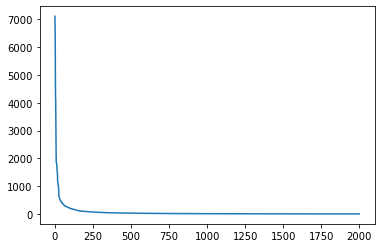

In [22]:
plt.plot(np.arange(2000), tags_counts[:2000])
plt.show()

In [23]:
n_tags = 1000
n_train, n_test = train_data.shape[0], test_data.shape[0]
top_tags = unique_tags[:n_tags]
tags_features = np.zeros((n_train + n_test, n_tags), dtype=np.int8)

for i, (_, tags_list) in enumerate(tags.items()):
    for j, tag in enumerate(top_tags):
        if tag in tags_list:
            tags_features[i: j] = 1

tags_train = tags_features[:n_train]
tags_test = tags_features[n_train:]

In [24]:
tags_train_csr = sparse.csr_matrix(tags_features[:n_train])
tags_test_csr = sparse.csr_matrix(tags_features[n_train:])

## EDA
Распределение классов равномерое, так что никаких дополнительных действий по баласировке не требуется

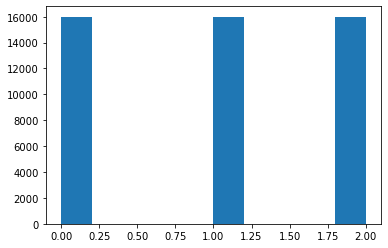

In [25]:
plt.hist(labels)
plt.show()

## Train-test Split

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_val, x_train_tags, x_val_tags, y_train, y_val = train_test_split(train_data, tags_train, labels, test_size=.1, stratify=labels, random_state=0)

## Preprocessing

### BOW

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def apply_bow(train_data, test_data):
    bow = CountVectorizer()
    train_bow = bow.fit_transform(train_data)
    test_bow= bow.transform(test_data)
    return train_bow, test_bow

In [28]:
x_train_title_bow, x_val_title_bow = apply_bow(x_train.Title, x_val.Title)
x_train_body_bow, x_val_body_bow = apply_bow(x_train.Body, x_val.Body)

In [29]:
x_train_bow = sparse.hstack([x_train_title_bow, x_train_body_bow, x_train_tags])
x_val_bow = sparse.hstack([x_val_title_bow, x_val_body_bow, x_val_tags])

### TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

def apply_tfidf(train_data, test_data):
    tfidf = TfidfVectorizer()
    train_tfidf = tfidf.fit_transform(train_data)
    test_tfidf = tfidf.transform(test_data)
    return train_tfidf, test_tfidf

In [31]:
x_train_title_tfidf, x_val_title_tfidf = apply_tfidf(x_train.Title, x_val.Title)
x_train_body_tfidf, x_val_body_tfidf = apply_tfidf(x_train.Body, x_val.Body)

In [32]:
x_train_tfidf = sparse.hstack([x_train_title_tfidf, x_train_body_tfidf, x_train_tags])
x_val_tfidf = sparse.hstack([x_val_title_tfidf, x_val_body_tfidf, x_val_tags])

### Word2Vec

In [33]:
from gensim import downloader
w2v_model = downloader.load('word2vec-google-news-300')

In [34]:
def sentence2vec(sentence, model):
    vecs = []
    for word in sentence.split(' '):
        try:
            vecs.append(w2v_model.get_vector(word.lower()))
        except:
            pass
    if len(vecs) == 0:
        vecs = [np.zeros(300)]
    return sum(vecs) / len(vecs)

def apply_word2vec(data):
    title = np.array([sentence2vec(sentence, w2v_model) for sentence in data['Title']])
    body = np.array([sentence2vec(sentence, w2v_model) for sentence in data['Body']])
    return np.hstack([title, body])

In [35]:
x_train_w2v = np.hstack([apply_word2vec(x_train), x_train_tags])
x_val_w2v = np.hstack([apply_word2vec(x_val), x_val_tags])

### Glove

In [36]:
glove_model = downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [37]:
def apply_glove(data):
    title = np.array([sentence2vec(sentence, glove_model) for sentence in data['Title']])
    body = np.array([sentence2vec(sentence, glove_model) for sentence in data['Body']])
    return np.hstack([title, body])

In [38]:
x_train_glove = np.hstack([apply_glove(x_train), x_train_tags])
x_val_glove = np.hstack([apply_glove(x_val), x_val_tags])

## Classical ML

Подготовим инфраструктуру для валидации моделей и подбора лучших параметров. Из алгоритмов будем использовать логистическую регрссию и ансамбль kNN + Random Forest + LogReg

In [42]:
from sklearn.ensemble import StackingClassifier

def get_log_reg(trial=None, C=1):
    from sklearn.linear_model import LogisticRegression

    if trial is not None:
        C = trial.suggest_loguniform('C', 1e-5, 1e+3)

    return LogisticRegression(C=C, max_iter=10000, random_state=0)

def get_stacking(trial=None,
                 n_neighbors=5,
                 n_estimators=100, min_samples_split=2, min_samples_leaf=1,
                 C=1):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression

    if trial is not None:
        n_neighbors = trial.suggest_int('n_neighbors', 5, 100)
        n_estimators = trial.suggest_int('n_estimators', 50, 500)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        C = trial.suggest_loguniform('C', 1e-5, 1e+3)

    estimators = [
        ('knn', KNeighborsClassifier(n_neighbors=n_neighbors)),
        ('rf', RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf, random_state=0))
    ]
    final = LogisticRegression(C=C, max_iter=10000, random_state=0)

    return StackingClassifier(estimators=estimators, final_estimator=final)

In [40]:
from sklearn.metrics import accuracy_score

def objective_function(estimator_func, train_data, train_labels, test_data, test_labels=None, trial=None):
    estimator = estimator_func(trial=trial).fit(train_data, train_labels)
    if test_labels is not None:
        prediction = estimator.predict(test_data)
        return accuracy_score(test_labels, prediction)
    else:
        return estimator.predict(test_data)

In [41]:
def optimize(estimator_func, train_data, train_labels, test_data, test_labels, n_trials=10):
    study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123),
                                direction='maximize',
                                pruner=optuna.pruners.HyperbandPruner())
    objective = lambda trial: objective_function(estimator_func, train_data, train_labels, test_data, test_labels, trial)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

## LogReg

In [44]:
validation_data = [
    (x_train_bow, x_val_bow),
    (x_train_tfidf, x_val_tfidf),
    (x_train_w2v, x_val_w2v),
    (x_train_glove, x_val_glove),
]
validation_names = ['bow', 'tfidf', 'word2vec', 'glove']

In [45]:
log_reg_studies = []
for x_train, x_val in validation_data:
    study = optimize(get_log_reg, x_train, y_train, x_val, y_val)
    log_reg_studies.append(study)

[I 2021-12-04 13:35:27,457] A new study created in memory with name: no-name-997cf3ed-39af-4a0b-9ac5-b71bbc3203fa
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
 10%|█         | 1/10 [03:21<30:11, 201.25s/it]

[I 2021-12-04 13:38:48,708] Trial 0 finished with value: 0.8039583333333333 and parameters: {'C': 3.730383528143731}. Best is trial 0 with value: 0.8039583333333333.


 20%|██        | 2/10 [03:38<12:22, 92.85s/it] 

[I 2021-12-04 13:39:05,685] Trial 1 finished with value: 0.8185416666666666 and parameters: {'C': 0.0019458738403480128}. Best is trial 1 with value: 0.8185416666666666.


 30%|███       | 3/10 [03:51<06:36, 56.65s/it]

[I 2021-12-04 13:39:19,245] Trial 2 finished with value: 0.7895833333333333 and parameters: {'C': 0.0006528473243309113}. Best is trial 1 with value: 0.8185416666666666.


 40%|████      | 4/10 [05:25<07:07, 71.20s/it]

[I 2021-12-04 13:40:52,759] Trial 3 finished with value: 0.823125 and parameters: {'C': 0.25734643279726915}. Best is trial 3 with value: 0.823125.


 50%|█████     | 5/10 [08:40<09:40, 116.09s/it]

[I 2021-12-04 13:44:08,453] Trial 4 finished with value: 0.8029166666666666 and parameters: {'C': 5.698384608345687}. Best is trial 3 with value: 0.823125.


 60%|██████    | 6/10 [09:22<06:02, 90.65s/it] 

[I 2021-12-04 13:44:49,705] Trial 5 finished with value: 0.8325 and parameters: {'C': 0.024257815076676004}. Best is trial 5 with value: 0.8325.


 70%|███████   | 7/10 [15:22<08:56, 178.85s/it]

[I 2021-12-04 13:50:50,134] Trial 6 finished with value: 0.7895833333333333 and parameters: {'C': 701.6387837751602}. Best is trial 5 with value: 0.8325.


 80%|████████  | 8/10 [18:01<05:44, 172.48s/it]

[I 2021-12-04 13:53:28,970] Trial 7 finished with value: 0.80375 and parameters: {'C': 3.0104949891579693}. Best is trial 5 with value: 0.8325.


 90%|█████████ | 9/10 [19:02<02:17, 137.51s/it]

[I 2021-12-04 13:54:29,595] Trial 8 finished with value: 0.8295833333333333 and parameters: {'C': 0.0703809641382708}. Best is trial 5 with value: 0.8325.


100%|██████████| 10/10 [19:35<00:00, 117.57s/it]
[I 2021-12-04 13:55:03,170] A new study created in memory with name: no-name-15acf5cb-3848-46ba-a335-f531edf3917b
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2021-12-04 13:55:03,165] Trial 9 finished with value: 0.8354166666666667 and parameters: {'C': 0.013706928443177698}. Best is trial 9 with value: 0.8354166666666667.


 10%|█         | 1/10 [02:09<19:29, 129.99s/it]

[I 2021-12-04 13:57:13,161] Trial 0 finished with value: 0.8189583333333333 and parameters: {'C': 3.730383528143731}. Best is trial 0 with value: 0.8189583333333333.


 20%|██        | 2/10 [02:14<07:27, 55.89s/it] 

[I 2021-12-04 13:57:17,187] Trial 1 finished with value: 0.7108333333333333 and parameters: {'C': 0.0019458738403480128}. Best is trial 0 with value: 0.8189583333333333.


 30%|███       | 3/10 [02:17<03:44, 32.06s/it]

[I 2021-12-04 13:57:20,889] Trial 2 finished with value: 0.6908333333333333 and parameters: {'C': 0.0006528473243309113}. Best is trial 0 with value: 0.8189583333333333.


 40%|████      | 4/10 [02:55<03:25, 34.19s/it]

[I 2021-12-04 13:57:58,327] Trial 3 finished with value: 0.8177083333333334 and parameters: {'C': 0.25734643279726915}. Best is trial 0 with value: 0.8189583333333333.


 50%|█████     | 5/10 [05:07<05:47, 69.48s/it]

[I 2021-12-04 14:00:10,389] Trial 4 finished with value: 0.816875 and parameters: {'C': 5.698384608345687}. Best is trial 0 with value: 0.8189583333333333.


 60%|██████    | 6/10 [05:22<03:24, 51.07s/it]

[I 2021-12-04 14:00:25,725] Trial 5 finished with value: 0.7758333333333334 and parameters: {'C': 0.024257815076676004}. Best is trial 0 with value: 0.8189583333333333.


 70%|███████   | 7/10 [11:24<07:37, 152.61s/it]

[I 2021-12-04 14:06:27,394] Trial 6 finished with value: 0.793125 and parameters: {'C': 701.6387837751602}. Best is trial 0 with value: 0.8189583333333333.


 80%|████████  | 8/10 [13:01<04:30, 135.04s/it]

[I 2021-12-04 14:08:04,806] Trial 7 finished with value: 0.8197916666666667 and parameters: {'C': 3.0104949891579693}. Best is trial 7 with value: 0.8197916666666667.


 90%|█████████ | 9/10 [13:25<01:40, 100.29s/it]

[I 2021-12-04 14:08:28,679] Trial 8 finished with value: 0.798125 and parameters: {'C': 0.0703809641382708}. Best is trial 7 with value: 0.8197916666666667.


100%|██████████| 10/10 [13:35<00:00, 81.58s/it]
[I 2021-12-04 14:08:38,987] A new study created in memory with name: no-name-5b5b40bc-5fb6-444f-8054-12ca7dfede70
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2021-12-04 14:08:38,982] Trial 9 finished with value: 0.7608333333333334 and parameters: {'C': 0.013706928443177698}. Best is trial 7 with value: 0.8197916666666667.


 10%|█         | 1/10 [01:18<11:43, 78.19s/it]

[I 2021-12-04 14:09:57,183] Trial 0 finished with value: 0.630625 and parameters: {'C': 3.730383528143731}. Best is trial 0 with value: 0.630625.


 20%|██        | 2/10 [01:24<04:47, 35.91s/it]

[I 2021-12-04 14:10:03,497] Trial 1 finished with value: 0.5475 and parameters: {'C': 0.0019458738403480128}. Best is trial 0 with value: 0.630625.


 30%|███       | 3/10 [01:27<02:26, 20.92s/it]

[I 2021-12-04 14:10:06,578] Trial 2 finished with value: 0.5289583333333333 and parameters: {'C': 0.0006528473243309113}. Best is trial 0 with value: 0.630625.


 40%|████      | 4/10 [02:07<02:50, 28.35s/it]

[I 2021-12-04 14:10:46,322] Trial 3 finished with value: 0.6285416666666667 and parameters: {'C': 0.25734643279726915}. Best is trial 0 with value: 0.630625.


 50%|█████     | 5/10 [03:41<04:20, 52.06s/it]

[I 2021-12-04 14:12:20,416] Trial 4 finished with value: 0.63 and parameters: {'C': 5.698384608345687}. Best is trial 0 with value: 0.630625.


 60%|██████    | 6/10 [03:58<02:40, 40.12s/it]

[I 2021-12-04 14:12:37,350] Trial 5 finished with value: 0.5995833333333334 and parameters: {'C': 0.024257815076676004}. Best is trial 0 with value: 0.630625.


 70%|███████   | 7/10 [05:43<03:04, 61.51s/it]

[I 2021-12-04 14:14:22,895] Trial 6 finished with value: 0.6308333333333334 and parameters: {'C': 701.6387837751602}. Best is trial 6 with value: 0.6308333333333334.


 80%|████████  | 8/10 [07:06<02:16, 68.34s/it]

[I 2021-12-04 14:15:45,878] Trial 7 finished with value: 0.6308333333333334 and parameters: {'C': 3.0104949891579693}. Best is trial 6 with value: 0.6308333333333334.


 90%|█████████ | 9/10 [07:32<00:54, 54.97s/it]

[I 2021-12-04 14:16:11,447] Trial 8 finished with value: 0.6114583333333333 and parameters: {'C': 0.0703809641382708}. Best is trial 6 with value: 0.6308333333333334.


100%|██████████| 10/10 [07:46<00:00, 46.63s/it]
[I 2021-12-04 14:16:25,317] A new study created in memory with name: no-name-a08e4380-cbd3-494e-a552-35a2cbde7c14
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2021-12-04 14:16:25,312] Trial 9 finished with value: 0.58375 and parameters: {'C': 0.013706928443177698}. Best is trial 6 with value: 0.6308333333333334.


 10%|█         | 1/10 [01:15<11:16, 75.17s/it]

[I 2021-12-04 14:17:40,488] Trial 0 finished with value: 0.630625 and parameters: {'C': 3.730383528143731}. Best is trial 0 with value: 0.630625.


 20%|██        | 2/10 [01:21<04:35, 34.46s/it]

[I 2021-12-04 14:17:46,450] Trial 1 finished with value: 0.5475 and parameters: {'C': 0.0019458738403480128}. Best is trial 0 with value: 0.630625.


 30%|███       | 3/10 [01:24<02:20, 20.08s/it]

[I 2021-12-04 14:17:49,420] Trial 2 finished with value: 0.5289583333333333 and parameters: {'C': 0.0006528473243309113}. Best is trial 0 with value: 0.630625.


 40%|████      | 4/10 [02:01<02:41, 26.98s/it]

[I 2021-12-04 14:18:26,966] Trial 3 finished with value: 0.6285416666666667 and parameters: {'C': 0.25734643279726915}. Best is trial 0 with value: 0.630625.


 50%|█████     | 5/10 [03:29<04:05, 49.09s/it]

[I 2021-12-04 14:19:55,272] Trial 4 finished with value: 0.63 and parameters: {'C': 5.698384608345687}. Best is trial 0 with value: 0.630625.


 60%|██████    | 6/10 [03:45<02:31, 37.82s/it]

[I 2021-12-04 14:20:11,218] Trial 5 finished with value: 0.5995833333333334 and parameters: {'C': 0.024257815076676004}. Best is trial 0 with value: 0.630625.


 70%|███████   | 7/10 [05:27<02:56, 58.80s/it]

[I 2021-12-04 14:21:53,197] Trial 6 finished with value: 0.6308333333333334 and parameters: {'C': 701.6387837751602}. Best is trial 6 with value: 0.6308333333333334.


 80%|████████  | 8/10 [06:49<02:12, 66.08s/it]

[I 2021-12-04 14:23:14,858] Trial 7 finished with value: 0.6308333333333334 and parameters: {'C': 3.0104949891579693}. Best is trial 6 with value: 0.6308333333333334.


 90%|█████████ | 9/10 [07:14<00:53, 53.25s/it]

[I 2021-12-04 14:23:39,896] Trial 8 finished with value: 0.6114583333333333 and parameters: {'C': 0.0703809641382708}. Best is trial 6 with value: 0.6308333333333334.


100%|██████████| 10/10 [07:28<00:00, 44.83s/it]

[I 2021-12-04 14:23:53,616] Trial 9 finished with value: 0.58375 and parameters: {'C': 0.013706928443177698}. Best is trial 6 with value: 0.6308333333333334.


In [46]:
print('Best scores:')
for study, name in zip(log_reg_studies, validation_names):
    print(f'\t{name}:\t{study.best_value}')

Best scores:
	bow:	0.8354166666666667
	tfidf:	0.8197916666666667
	word2vec:	0.6308333333333334
	glove:	0.6308333333333334


### Stacking
Запустил только на одну попытку из-за того, что тренировка занимает очень много времени. В целом, точность там примерно такая же, как и на логистической регрессии

In [96]:
stacking_studies = []
for x_train, x_val in validation_data:
    study = optimize(get_stacking, x_train, y_train, x_val, y_val, n_trials=1)
    stacking_studies.append(study)

[I 2021-12-05 16:47:44,953] A new study created in memory with name: no-name-6f3f8772-ce02-48ec-a205-a210d9e18710
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
100%|██████████| 1/1 [12:32<00:00, 752.76s/it]
[I 2021-12-05 17:00:17,721] A new study created in memory with name: no-name-8dc416f4-435f-4dd0-bd8a-617be060750e
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2021-12-05 17:00:17,713] Trial 0 finished with value: 0.7879166666666667 and parameters: {'n_neighbors': 71, 'n_estimators': 179, 'min_samples_split': 4, 'min_samples_leaf': 6, 'C': 5.698384608345687}. Best is trial 0 with value: 0.7879166666666667.


100%|██████████| 1/1 [11:36<00:00, 696.84s/it]
[I 2021-12-05 17:11:54,568] A new study created in memory with name: no-name-094c27f1-b6e9-42ca-a14a-4f603bd7254c
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2021-12-05 17:11:54,559] Trial 0 finished with value: 0.8045833333333333 and parameters: {'n_neighbors': 71, 'n_estimators': 179, 'min_samples_split': 4, 'min_samples_leaf': 6, 'C': 5.698384608345687}. Best is trial 0 with value: 0.8045833333333333.


100%|██████████| 1/1 [12:48<00:00, 768.30s/it]
[I 2021-12-05 17:24:42,870] A new study created in memory with name: no-name-9a6d132d-a3a4-4df1-948a-acd9713a32fe
C:\Users\nikti\miniconda3\envs\nlp\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[I 2021-12-05 17:24:42,864] Trial 0 finished with value: 0.5997916666666666 and parameters: {'n_neighbors': 71, 'n_estimators': 179, 'min_samples_split': 4, 'min_samples_leaf': 6, 'C': 5.698384608345687}. Best is trial 0 with value: 0.5997916666666666.


100%|██████████| 1/1 [10:33<00:00, 633.84s/it]

[I 2021-12-05 17:35:16,708] Trial 0 finished with value: 0.5997916666666666 and parameters: {'n_neighbors': 71, 'n_estimators': 179, 'min_samples_split': 4, 'min_samples_leaf': 6, 'C': 5.698384608345687}. Best is trial 0 with value: 0.5997916666666666.


In [97]:
print('Best scores:')
for study, name in zip(stacking_studies, validation_names):
    print(f'\t{name}:\t{study.best_value}')

Best scores:
	bow:	0.7879166666666667
	tfidf:	0.8045833333333333
	word2vec:	0.5997916666666666
	glove:	0.5997916666666666


## Neural Network

In [79]:
import time
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer

Подготовим кастомный датасет для наших данных

In [80]:
class StackOverflowDataset(Dataset):
    def __init__(self, filename) -> None:
        super().__init__()
        self.data = pd.read_parquet(filename)

        self.title = self.data['Title']
        self.body = self.data['Body']
        self.tags = self.data['Tags']
        self.target = self.data['target'] if 'target' in self.data.columns else None

        def split_tags(text):
            return ' '.join(text[1: -1].split('><'))
        self.tags = self.tags.apply(lambda x: split_tags(x))

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data = self.title.iloc[idx] + self.body.iloc[idx] + self.tags.iloc[idx]
        if self.target is not None:
            return data, self.target.iloc[idx]
        else:
            return data

In [81]:
train_iter = StackOverflowDataset('./data/train.parquet')

In [82]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [83]:
text_pipeline = lambda x: vocab(tokenizer(x))

In [84]:
device = torch.device("cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_text, _label) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = StackOverflowDataset('./data/train.parquet')
dataloader = DataLoader(train_iter, batch_size=32, collate_fn=collate_batch)

Собственно сама нейронка со слоем эмбеддингов и двумя fully-connected слоями

In [90]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        linear_output = self.fc(embedded)
        return self.fc2(linear_output)

In [91]:
train_iter = StackOverflowDataset('./data/train.parquet')
num_class = len(set([label for (_, label) in train_iter]))
vocab_size = len(vocab)
emsize = 128
hidden_dim = 32
model = TextClassificationModel(vocab_size, emsize, hidden_dim, num_class).to(device)

In [92]:
def train(dataloader, optimizer, epoch, criterion):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for label, text, offsets in dataloader:
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [93]:
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter = StackOverflowDataset('./data/train.parquet')
test_iter = StackOverflowDataset('./data/test.parquet')

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [94]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, optimizer, epoch, criterion)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
    print('-' * 59)

| epoch   1 |   500/  713 batches | accuracy    0.683
-----------------------------------------------------------
| end of epoch   1 | time: 24.61s | valid accuracy    0.806 
-----------------------------------------------------------
| epoch   2 |   500/  713 batches | accuracy    0.811
-----------------------------------------------------------
| end of epoch   2 | time: 24.14s | valid accuracy    0.833 
-----------------------------------------------------------
| epoch   3 |   500/  713 batches | accuracy    0.847
-----------------------------------------------------------
| end of epoch   3 | time: 24.39s | valid accuracy    0.820 
-----------------------------------------------------------
| epoch   4 |   500/  713 batches | accuracy    0.892
-----------------------------------------------------------
| end of epoch   4 | time: 25.23s | valid accuracy    0.872 
-----------------------------------------------------------
| epoch   5 |   500/  713 batches | accuracy    0.893
------

## Итоги
Ожидаемо, алгоритмы классического машинного обучения показали себя хуже Deep Learning.

Из препроцессинга лучше всего себя показал BOW, близко к нему TF-IDF. А вот предобученные модели, Word2Vec и Glove, не дали прироста к точности